In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#gmask='/homes/kpegion/projects/finished/mappnmmepred/monthly/src/giorgi/giorgimask.nc'
#ds_gmask=xr.open_dataset(gmask).squeeze()
#ds_gmask

ds_gmask=utils.getGiorgiMask()
ds_gmask

<xarray.Dataset>
Dimensions:     (lat: 181, lon: 360)
Coordinates:
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    time        datetime64[ns] 1982-01-01
Data variables:
    giorgimask  (lat, lon) float64 ...
Attributes:
    title:         Giorgi Mask
    long_title:    NMME Giorgi Mask
    comments:      
    institution:   GMU/COLA
    source:        ME
    CreationDate:  2016/08/04 13:46:15
    CreatedBy:     kpegion
    MatlabSource:  makeGiorgiMask

<xarray.DataArray 'giorgimask' (lat: 35, lon: 101)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  9., nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 25.0 26.0 27.0 28.0 29.0 ... 55.0 56.0 57.0 58.0 59.0
  * lon      (lon) float64 200.0 201.0 202.0 203.0 ... 297.0 298.0 299.0 300.0
    time     datetime64[ns] 1982-01-01
Attributes:
    name:       giorgimask
    long_name:  giorgimask
    units:      none


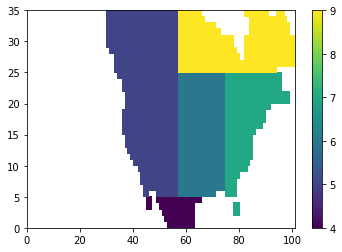

In [4]:
#tmp=ds_gmask['giorgimask'].sel(lat=slice(25,59),lon=slice(200,300))
#print(tmp)
tmp=utils.selCONUS(ds_gmask['giorgimask'])
print(tmp)
plt.pcolormesh(tmp)
plt.colorbar()

In [5]:
groups=['ECCC','ESRL','NCEP','RSMAS',
        'EMC','GMAO','NRL','CESM','CESM']

models=['GEM','FIMr1p1','CFSv2','CCSM4',
       'GEFS','GEOS_V2p1','NESM','46LCESM1',
       '30LCESM1']

In [6]:
varname='pr'
varlev='sfc'
dataset='CPC-PRECIP'
basepath='/shared/subx/'
modelpath=basepath+'hindcast/'+varname+varlev+'/daily/anoms/'
verifpath=basepath+'verif/prsfc/daily/anoms/'+dataset+'/'
file_stub='_????01*.anoms.daily'
gregions=['ENA','CNA','WNA']
gregnums=[5,6,7]

smoothlist=[1,7,14,21,28,30]
smoothcolors=['k','r','b','g','y','c']

#### Read verif Data and Get Giorgi Regions

In [7]:
files_verif=utils.getSubxVerifFiles(verifpath,dataset,
                                    varname,varlev,
                                    file_stub)
ds_verif=xr.open_mfdataset(files_verif,
                           combine='nested',
                           concat_dim='ic')  
ds_verif=utils.setCoords(ds_verif,files_verif)    
ds_giorgi_verif=utils.makeGiorgiRegions(ds_verif,ds_gmask,
                                        gregions,gregnums).persist()

In makeGiorgi
<xarray.Dataset>
Dimensions:  (ic: 682, lat: 181, lon: 360, time: 45)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 35 36 37 38 39 40 41 42 43 44
  * ic       (ic) datetime64[ns] 1999-01-01 1999-01-02 ... 2020-01-30 2020-01-31
Data variables:
    pr       (ic, time, lat, lon) float32 dask.array<chunksize=(1, 45, 181, 360), meta=np.ndarray>
Attributes:
    title:         SubX Verification Anomalies
    long_title:    SubX Verification Anomalies
    comments:      SubX project http://cola.gmu.edu/~kpegion/subx/
    institution:   IRI
    source:        SubX IRI
    CreationDate:  2018/07/01 19:37:54
    CreatedBy:     kpegion
    MatlabSource:  


#### Read Model Data and Get Giorgi regions (Jan ICs only for now)

In [ ]:
all_list=[]

for i,(group,model) in enumerate(zip(groups,models)):

    print(group,model)
    
    # File names
#    files_model=modelpath+group+'-'+model+'/'+varname+'_'+varlev+'_'+group+'-'+model+'_????01*.anoms.daily.nc'
#    files_model=sorted(glob.glob(files_model))
    files_model=utils.getSubxFiles(modelpath,model,group,
                                   varname,varlev,file_stub)    

    # Read model data, assign ic and time dates
    ds_model=xr.open_mfdataset(files_model,combine='nested',
                               concat_dim='ic')

    ds_model=utils.setCoords(ds_model,files_model)    
#    ds_model['ic']=utils.getFcstDates(files_model)
#    nt=len(ds_model['time'])
#    ds_model['time']=np.arange(nt)
#    ds_model=ds_model.dropna(dim='ic',how='all')   
    
    # Reverse lats if needed
#    if (ds_model['lat'][0]>ds_model['lat'][-1]):
#        ds_model=ds_model.reindex(lat=list(reversed(ds_model['lat'])))
    
    ds_model=utils.reverseLats(ds_model)
    
    # Assign the giorgi mask as a coordinate
    ds_model.coords['gmask'] = (('lat', 'lon'), 
                                ds_gmask['giorgimask'].squeeze())
    
    # Get giorgi regions
    ds_giorgi_model=utils.makeGiorgiRegions(ds_model,ds_gmask,
                                            gregions,gregnums).persist()

    # Change units to mm/day
#    ds_model=ds_model*86400.0
    
    # Calc correlations
    corr=utils.calcSkill(ds_giorgi_model,
                         ds_giorgi_verif,
                         gregions).persist()
    
    # Plot correlations
    figname='conus_giorgi_skill_'+group+'-'+model
    utils.plotSkill(corr,
                    gregions,
                    figname)
    
    # Calculate correlations in sliding window
    skill_tmp=utils.calcSkillSliding(ds_giorgi_model,
                                     ds_giorgi_verif,
                                     gregions,
                                     smoothlist)
    
    # Combine the sliding skill together into a dimension
    tmp=xr.combine_nested(skill_tmp,concat_dim='swin').compute()
    
    # Add the sliding window skill to the giant list for this model
    all_list.append(tmp)

#### Test plotting of sliding window skill

In [ ]:
all_models=xr.combine_nested(all_list,concat_dim='model')
all_models=all_models.persist()
all_models['model']=models
all_models['swin']=smoothlist
all_models

In [ ]:
#all_models.to_netcdf('all_models_acc_CONUS_giorgi.1-12.nc')

In [ ]:
fig=plt.figure(figsize=(8.5,11))

for i,reg in enumerate(gregions):
    
    plt.subplot(3,1,i+1)

    for iwin,(c,w) in enumerate(zip(smoothcolors,smoothlist)):
        
        # Plot each model
        for imodel,m in enumerate(models):
            plt.plot(all_models['time'],
                     all_models[reg][imodel,iwin,:].T,
                     color=c,linestyle='-',alpha=0.8)  
#        if (i==0):
#            plt.legend([str(x) for x in smoothlist],
#                        title='Window (days)')

            
    plt.ylim(-0.3,1.0)
    plt.grid(True)
    plt.xlabel('lead(days)')
    plt.ylabel('ACC')
    plt.title(reg)
        
# Big title at the top        
plt.suptitle('SubX Ensemble Mean Precipitation Skill; All ICs')

plt.tight_layout()

#plt.savefig('../figs/all_models_acc_CONUS_giorgi.1-12.png')